In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from shap import TreeExplainer, summary_plot
from typing import List, Tuple

/home/uif29913/atc-hackathon/atcenv/lib64/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
OTHER_COLS: List[str] = [
    'indicator',
    'temperature',
    'precipitation',
    'humidity'
]

POSTS: List[str] = [
    'IT (p1)',
    'Bridge (p3)',
    'ISCA UA (p35)'
]

WEEKDAYS: List[str] = [
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday'
]

PLACES: List[str] = [
    'Nº Bars',
    'Nº Parks',
    'Nº Restaurants',
    'Nº Schools',
    'Nº Points of Interest'
    
]

HOURS: List[str] = ['{:02d}h'.format(h) for h in range(0, 24)]
MINUTES: List[str] = ['{:02d}m'.format(h) for h in range(0, 60, 15)]

In [3]:
def preprocess(data: pd.DataFrame, post: bool = True) -> Tuple[pd.DataFrame, pd.Series]:
    if not post:
        columns: List[str] = ['weekday', 'hour', 'minute']
        final_cols: list[str] = OTHER_COLS + PLACES + WEEKDAYS + HOURS + MINUTES 
    else:
        columns: List[str] = ['n_p', 'weekday', 'hour', 'minute']
        final_cols: list[str] = OTHER_COLS + PLACES + POSTS + WEEKDAYS + HOURS + MINUTES 
    
    # encode and fix column names
    data: pd.DataFrame = pd.get_dummies(data, columns=columns)
    data.columns: List[str] = final_cols

    
    # split dataset from labels
    y: pd.Series = data['indicator'].values
    X: pd.DataFrame = data.drop(['indicator'], axis=1)
    #print(y)
    return X, y

# 1. Global Regression Model

In [4]:
# load
data: pd.DataFrame = pd.read_parquet('s3://datalake-eu-central-1/ugiO-atchackathon/preprocessed/indicator_regression_plus_places.parquet')
data = data.drop(columns="n_p")

In [5]:
# preprocess
X, y = preprocess(data, post=False)


In [6]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X.head()

,temperature,precipitation,humidity,Nº Bars,Nº Parks,Nº Restaurants,Nº Schools,Nº Points of Interest,Monday,Tuesday,...,18h,19h,20h,21h,22h,23h,00m,15m,30m,45m
time_index,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00,16.6,98.0,0.0,1,1,0,0,2,0,0,...,0,0,0,0,0,0,1,0,0,0
2022-09-01 00:15:00,16.6,98.0,0.0,1,1,0,0,2,0,0,...,0,0,0,0,0,0,0,1,0,0
2022-09-01 00:30:00,16.4,98.0,0.0,1,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
2022-09-01 00:45:00,16.4,98.0,0.0,1,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
2022-09-01 01:00:00,16.4,98.0,0.0,1,1,0,0,2,0,0,...,0,0,0,0,0,0,1,0,0,0


In [8]:
# modeling
clf: LGBMRegressor = LGBMRegressor()
clf.fit(X_train, y_train)

LGBMRegressor()

In [9]:
# evaluate
y_pred: np.ndarray = clf.predict(X_test)

mae: float = mean_absolute_error(y_test, y_pred)
rmse: float = mean_squared_error(y_test, y_pred, squared=False)

print('MAE: ' + str(round(mae, 2)))
print('RMSE: ' + str(round(rmse, 2)))

MAE: 0.09
RMSE: 0.13


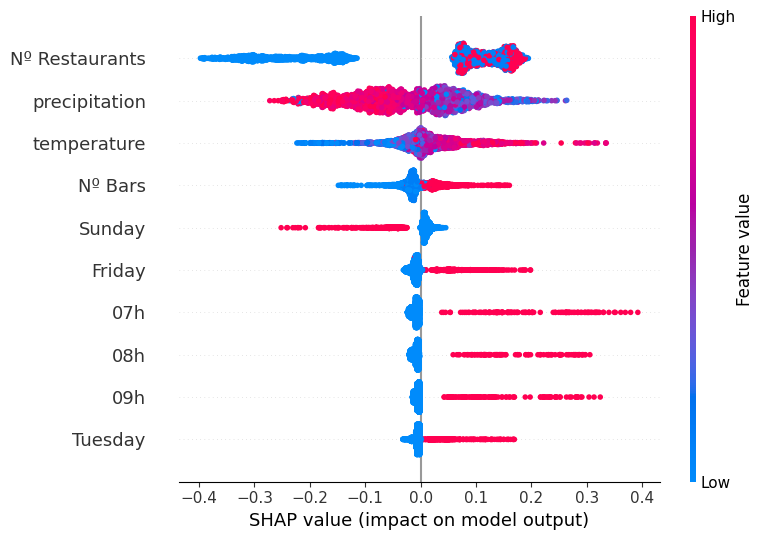

In [10]:
# explain
shap_values: np.ndarray = TreeExplainer(clf).shap_values(X_test)
summary_plot(shap_values, X_test, max_display=10, show=False)
plt.savefig('../../databases/plots/global_mobility_shap_plot.png')
plt.show()

In [11]:
# export
clf.booster_.save_model('../../databases/models/global_mobility_regressor.txt')

# 2. Local Regression Model

In [12]:
# load
data: pd.DataFrame = pd.read_parquet('s3://datalake-eu-central-1/ugiO-atchackathon/preprocessed/indicator_regression_plus_places.parquet')

Post: p1
MAE: 0.03
RMSE: 0.04


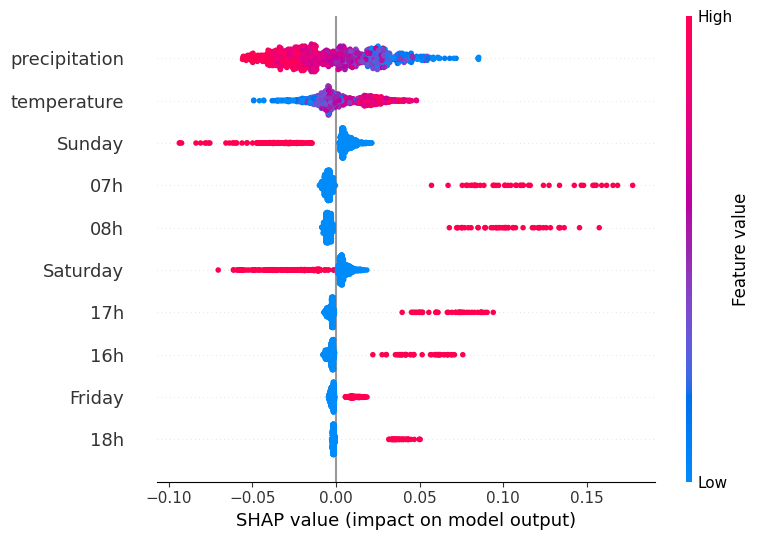

Post: p3
MAE: 0.08
RMSE: 0.1


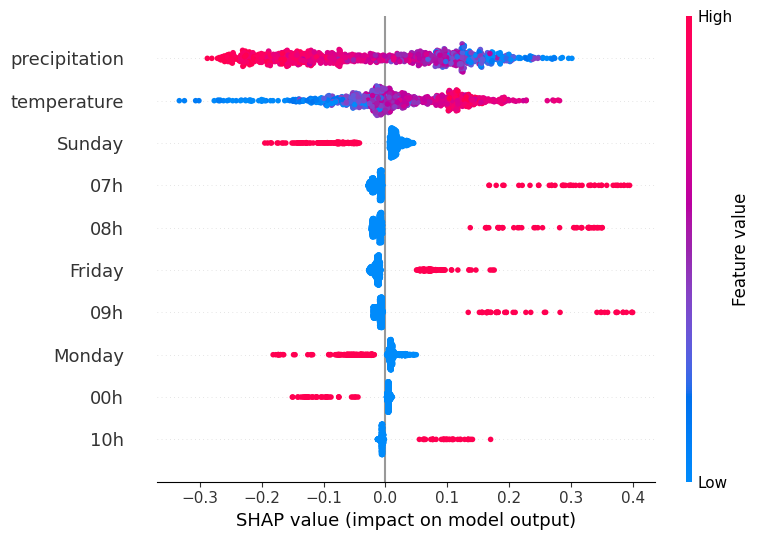

Post: p35
MAE: 0.13
RMSE: 0.18


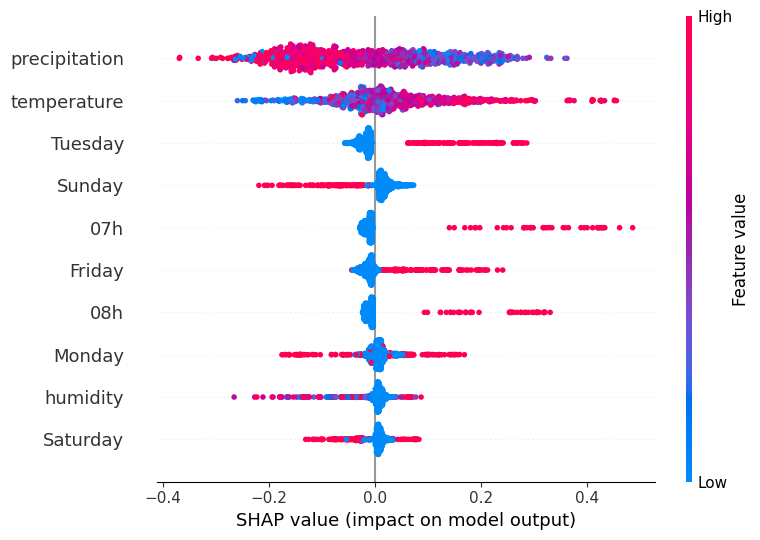

In [13]:
# independent model for each post
posts: List[str] = data['n_p'].unique().tolist()

for post in posts:
    # select only data related to this post
    temp: pd.DataFrame = data[data['n_p'] == post]
    temp: pd.DataFrame = temp.drop(['n_p'], axis=1)
    
    # preprocess
    X, y = preprocess(temp, post=False)
    X: pd.DataFrame = X.drop(columns=PLACES, axis=1)
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # modeling
    clf: LGBMRegressor = LGBMRegressor()
    clf.fit(X_train, y_train)
    
    # evaluate
    y_pred: np.ndarray = clf.predict(X_test)

    mae: float = mean_absolute_error(y_test, y_pred)
    rmse: float = mean_squared_error(y_test, y_pred, squared=False)

    print('Post: ' + post)
    print('MAE: ' + str(round(mae, 2)))
    print('RMSE: ' + str(round(rmse, 2)))
    
    # explain
    shap_values: np.ndarray = TreeExplainer(clf).shap_values(X_test)
    summary_plot(shap_values, X_test, max_display=10, show=False)
    plt.savefig('../../databases/plots/local_mobility_shap_plot_{}.png'.format(post))
    plt.show()
    
    # export
    clf.booster_.save_model('../../databases/models/local_mobility_regressor_{}.txt'.format(post))